<a href="https://colab.research.google.com/github/lili0706/CE6068_Final_Project/blob/main/method1%3AGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import entropy
import umap.umap_ as umap

In [ ]:
# ========= 1. 資料前處理 =========
df = pd.read_csv("/AODB.csv")
print(f"原始資料總筆數：{len(df)}")

# 篩選長度 3–6 的序列
# df['sequence'] = df['sequence'].astype(str).str.replace(' ', '', regex=False)
df = df[df['sequence'].apply(lambda x: 3 <= len(x) <= 6)]
print(f"篩選後長度 3–6 的序列筆數：{len(df)}")

# 建立 amino acid vocab
aa_vocab = sorted(set(''.join(df['sequence'])))
aa_to_idx = {aa: i+1 for i, aa in enumerate(aa_vocab)}  # 0 是 padding
idx_to_aa = {i: aa for aa, i in aa_to_idx.items()}
vocab_size = len(aa_to_idx) + 1
max_len = 6

print(f"胺基酸總類數：{len(aa_vocab)}")
print(f"胺基酸種類：{aa_vocab}")

# encode
def encode(seq):
    return [aa_to_idx[aa] for aa in seq] + [0]*(max_len - len(seq))

encoded_seqs = np.array([encode(seq) for seq in df['sequence']])
train_data, val_data = train_test_split(encoded_seqs, test_size=0.2, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

原始資料總筆數：1517
篩選後長度 3–6 的序列筆數：883
胺基酸總類數：21
胺基酸種類：[' ', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [ ]:
# ========= 2. GAN 模型 =========
latent_dim = 32

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, max_len * vocab_size),
            nn.Unflatten(1, (max_len, vocab_size)),
            nn.Softmax(dim=2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(max_len * vocab_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# ========= 3. 訓練 =========
def one_hot_encode(batch):
    return torch.nn.functional.one_hot(batch, num_classes=vocab_size).float()

batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(train_data)), batch_size=batch_size, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
criterion = nn.BCELoss()

epochs = 1500
g_losses, d_losses, kl_divs = [], [], []

for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    for real_batch, in train_loader:
        real_batch = one_hot_encode(real_batch.to(device))

        # 訓練 D
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = G(z).detach()
        d_real = D(real_batch)
        d_fake = D(fake_batch)

        d_loss = criterion(d_real, torch.ones_like(d_real)) + criterion(d_fake, torch.zeros_like(d_fake))
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 訓練 G
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = G(z)
        d_fake = D(fake_batch)

        g_loss = criterion(d_fake, torch.ones_like(d_fake))
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))

    # 每個 epoch 計算一次 KL 散度
    G.eval()
    with torch.no_grad():
        z = torch.randn(1000, latent_dim).to(device)
        gen_seqs = G(z).cpu().numpy()

    def get_aa_distribution(seqs):
        flat = ''.join([''.join([idx_to_aa.get(np.argmax(row), '') for row in seq]) for seq in seqs])
        count = {aa: flat.count(aa) for aa in aa_vocab}
        total = sum(count.values()) + 1e-8
        return np.array([count[aa]/total for aa in aa_vocab])

    def safe_distribution(dist):
        dist += 1e-8
        return dist / dist.sum()

    real_dist = safe_distribution(get_aa_distribution(one_hot_encode(torch.tensor(train_data)).numpy()))
    fake_dist = safe_distribution(get_aa_distribution(gen_seqs))
    kl = entropy(real_dist, fake_dist)

    # real_dist = get_aa_distribution(one_hot_encode(torch.tensor(train_data)).numpy())
    # fake_dist = get_aa_distribution(gen_seqs)
    # kl = entropy(real_dist, fake_dist)
    kl_divs.append(kl)

    print(f"Epoch {epoch+1:3}：  D Loss: {epoch_d_loss/len(train_loader):.4f} | G Loss: {epoch_g_loss/len(train_loader):.4f} | KL: {kl:.4f}")

Epoch   1：  D Loss: 1.3600 | G Loss: 0.6523 | KL: 0.3587
Epoch   2：  D Loss: 1.3272 | G Loss: 0.6731 | KL: 0.4048
Epoch   3：  D Loss: 1.2951 | G Loss: 0.6914 | KL: 0.4362
Epoch   4：  D Loss: 1.2651 | G Loss: 0.7082 | KL: 0.4243
Epoch   5：  D Loss: 1.2315 | G Loss: 0.7249 | KL: 0.6863
Epoch   6：  D Loss: 1.1987 | G Loss: 0.7418 | KL: 0.6612
Epoch   7：  D Loss: 1.1614 | G Loss: 0.7574 | KL: 1.1465
Epoch   8：  D Loss: 1.1365 | G Loss: 0.7701 | KL: 2.0215
Epoch   9：  D Loss: 1.1192 | G Loss: 0.7775 | KL: 4.6104
Epoch  10：  D Loss: 1.1120 | G Loss: 0.7750 | KL: 5.2405
Epoch  11：  D Loss: 1.1481 | G Loss: 0.7565 | KL: 6.9362
Epoch  12：  D Loss: 1.1922 | G Loss: 0.7288 | KL: 7.1156
Epoch  13：  D Loss: 1.2585 | G Loss: 0.6959 | KL: 6.7571
Epoch  14：  D Loss: 1.2977 | G Loss: 0.6909 | KL: 8.2686
Epoch  15：  D Loss: 1.3136 | G Loss: 0.6923 | KL: 8.0716
Epoch  16：  D Loss: 1.3249 | G Loss: 0.7082 | KL: 7.4398
Epoch  17：  D Loss: 1.3297 | G Loss: 0.7358 | KL: 6.2461
Epoch  18：  D Loss: 1.3258 | G 

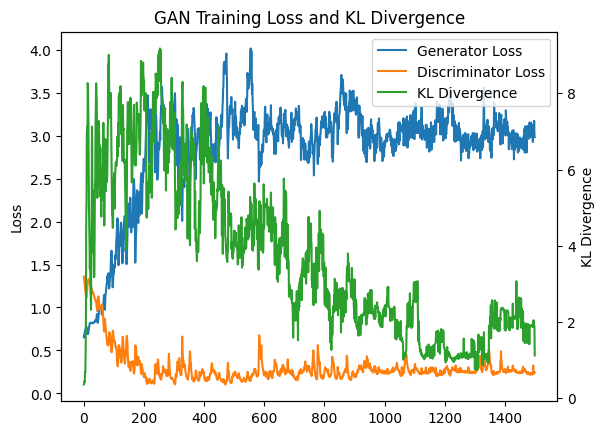

In [ ]:
# ========= 4a. Loss + KL Divergence 圖 =========
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(g_losses, label='Generator Loss', color='tab:blue')
ax1.plot(d_losses, label='Discriminator Loss', color='tab:orange')
ax1.set_ylabel('Loss')

ax2.plot(kl_divs, label='KL Divergence', color='tab:green', linestyle='-')
ax2.set_ylabel('KL Divergence')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("GAN Training Loss and KL Divergence")
plt.xlabel("Epoch")
plt.show()

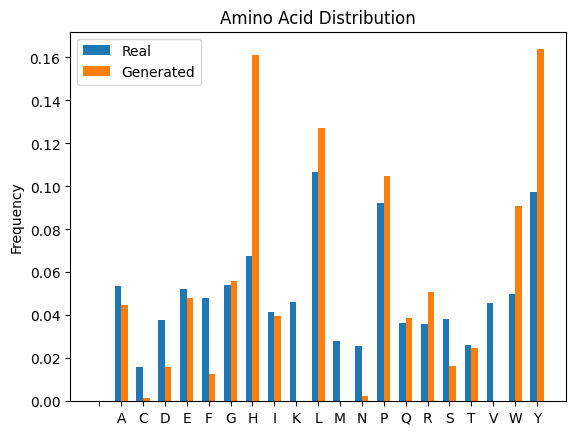

In [ ]:
# ========= 4b. Amino Acid 分佈圖 =========
x = np.arange(len(aa_vocab))
plt.bar(x - 0.15, real_dist, width=0.3, label="Real")
plt.bar(x + 0.15, fake_dist, width=0.3, label="Generated")
plt.xticks(x, aa_vocab)
plt.ylabel("Frequency")
plt.title("Amino Acid Distribution")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


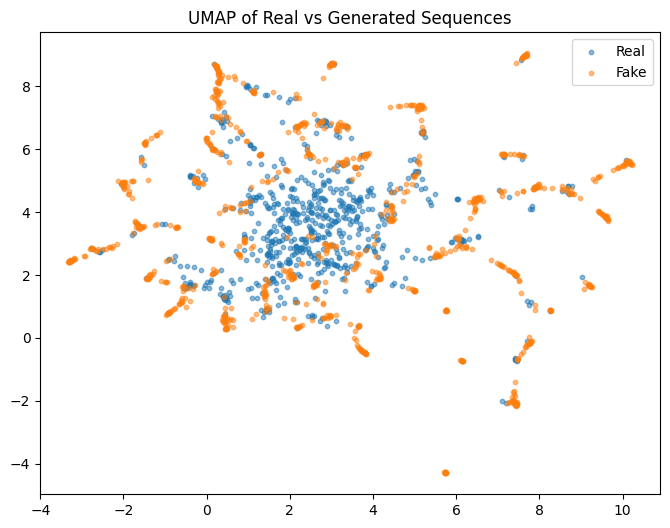

In [ ]:
# ========= 4c. UMAP =========
real_flat = one_hot_encode(torch.tensor(train_data)).view(-1, max_len * vocab_size).numpy()
fake_flat = gen_seqs.reshape(-1, max_len * vocab_size)

combined = np.vstack([real_flat, fake_flat])
labels = np.array(['Real'] * len(real_flat) + ['Fake'] * len(fake_flat))

reducer = umap.UMAP()
embedding = reducer.fit_transform(combined)

plt.figure(figsize=(8,6))
for label in ['Real', 'Fake']:
    idxs = labels == label
    plt.scatter(embedding[idxs,0], embedding[idxs,1], label=label, alpha=0.5, s=10)
plt.legend()
plt.title("UMAP of Real vs Generated Sequences")
plt.show()

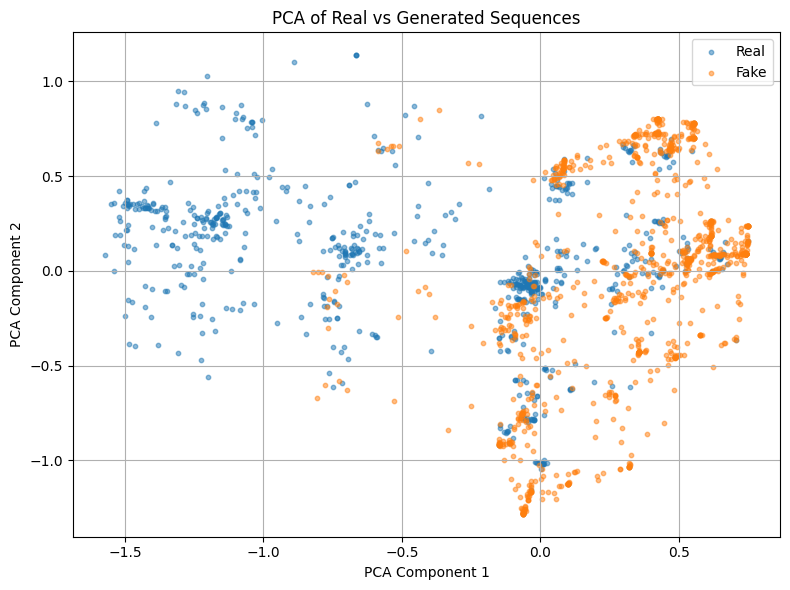

In [ ]:
from sklearn.decomposition import PCA

# ========= 4c. PCA =========
# 將 one-hot 的訓練與生成序列展平成向量
real_flat = one_hot_encode(torch.tensor(train_data)).view(-1, max_len * vocab_size).numpy()
fake_flat = gen_seqs.reshape(-1, max_len * vocab_size)

# 合併資料並產生標籤
combined = np.vstack([real_flat, fake_flat])
labels = np.array(['Real'] * len(real_flat) + ['Fake'] * len(fake_flat))

# 執行 PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(combined)

# 繪製 PCA 結果圖
plt.figure(figsize=(8, 6))
for label in ['Real', 'Fake']:
    idxs = labels == label
    plt.scatter(embedding[idxs, 0], embedding[idxs, 1], label=label, alpha=0.5, s=10)
plt.legend()
plt.title("PCA of Real vs Generated Sequences")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ========= 5. 輸出生成的 20 個序列 =========
print("\n=== 產生的 20 個序列 ===")
G.eval()
with torch.no_grad():
    z = torch.randn(5000, latent_dim).to(device)
    gen_probs = G(z).cpu()  # shape: (20, max_len, vocab_size)
    gen_indices = torch.argmax(gen_probs, dim=2)  # shape: (20, max_len)
    gen_seqs = gen_indices.numpy()

def decode(indices):
    return ''.join([idx_to_aa.get(idx, '-') for idx in indices if idx != 0])

for i, seq in enumerate(gen_seqs):
    print(f"[{i+1:2}] {decode(seq)}")


=== 產生的 20 個序列 ===
[ 1] GYS
[ 2] LLD
[ 3] LLD
[ 4] LWD
[ 5] YAE
[ 6] YHL
[ 7] GAE
[ 8] PYY
[ 9] LAH
[10] RWY
[11] PWH
[12] YYY
[13] PHH
[14] YYL
[15] LHE
[16] LHQ
[17] RWY
[18] LWI
[19] YHL
[20] RHY
[21] LHT
[22] LWH
[23] RHY
[24] LAG
[25] PHT
[26] PWH
[27] RHY
[28] GYY
[29] RHY
[30] RHQ
[31] LHH
[32] PHT
[33] YYL
[34] RWQ
[35] PHL
[36] LWH
[37] PHH
[38] LWH
[39] PWH
[40] GEY
[41] GYI
[42] GAFH
[43] RWI
[44] PHT
[45] GYI
[46] PHT
[47] LWQ
[48] PHH
[49] YYY
[50] LHR
[51] YYS
[52] PWH
[53] RHE
[54] RWQ
[55] LHR
[56] RWY
[57] LHE
[58] GYY
[59] LWD
[60] PHT
[61] LWH
[62] PHT
[63] PWS
[64] LLD
[65] RWQ
[66] YYS
[67] LAE
[68] LWQ
[69] PHH
[70] LHT
[71] PAG
[72] GYI
[73] PHG
[74] YYY
[75] PHS
[76] RWI
[77] LLD
[78] GYS
[79] RWI
[80] GYS
[81] RHY
[82] PYI
[83] YYY
[84] YHE
[85] RWY
[86] GYY
[87] RHY
[88] YYS
[89] GAEP
[90] GYI
[91] RWY
[92] LHQ
[93] PYS
[94] PWI
[95] PWY
[96] LHR
[97] PWT
[98] YYY
[99] YHE
[100] PHG
[101] LWQ
[102] YYE
[103] GAE
[104] PYS
[105] PHL
[106] YYSP
[107] RHY
[108] 

In [ ]:
# ========= 6. 分析 Discriminator 評分最高與最低的假序列 =========
print("\n=== Discriminator 評分最高的前 10 個假序列（最像真的） ===")
G.eval()
D.eval()

with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    fake_seqs = G(z)  # shape: (1000, max_len, vocab_size)
    d_scores = D(fake_seqs).squeeze().cpu().numpy()  # shape: (1000,)

    # 最像真的（分數高）
    top_k = 10
    top_indices = np.argsort(d_scores)[-top_k:][::-1].copy()
    top_seqs = torch.argmax(fake_seqs[top_indices].cpu(), dim=2).numpy()

    for i, (seq, score) in enumerate(zip(top_seqs, d_scores[top_indices])):
        decoded = decode(seq)
        print(f"[Top {i+1:2}] D Score = {score:.4f} | Seq: {decoded}")

    # 最不像真的（分數低）
    print("\n=== Discriminator 評分最低的前 10 個假序列（最不像真的） ===")
    bottom_indices = np.argsort(d_scores)[:top_k]
    bottom_seqs = torch.argmax(fake_seqs[bottom_indices].cpu(), dim=2).numpy()

    for i, (seq, score) in enumerate(zip(bottom_seqs, d_scores[bottom_indices])):
        decoded = decode(seq)
        print(f"[Bot {i+1:2}] D Score = {score:.4f} | Seq: {decoded}")


=== Discriminator 評分最高的前 10 個假序列（最像真的） ===
[Top  1] D Score = 0.7720 | Seq: GYY
[Top  2] D Score = 0.7045 | Seq: GYY
[Top  3] D Score = 0.6762 | Seq: GYE
[Top  4] D Score = 0.6532 | Seq: YLE
[Top  5] D Score = 0.5905 | Seq: GASP
[Top  6] D Score = 0.5477 | Seq: GYE
[Top  7] D Score = 0.5321 | Seq: GEY
[Top  8] D Score = 0.5289 | Seq: GYY
[Top  9] D Score = 0.5052 | Seq: GYE
[Top 10] D Score = 0.5009 | Seq: HHH

=== Discriminator 評分最低的前 10 個假序列（最不像真的） ===
[Bot  1] D Score = 0.0003 | Seq: GAF
[Bot  2] D Score = 0.0005 | Seq: PAH
[Bot  3] D Score = 0.0008 | Seq: YAL
[Bot  4] D Score = 0.0009 | Seq: LAH
[Bot  5] D Score = 0.0010 | Seq: PQH
[Bot  6] D Score = 0.0010 | Seq: PHL
[Bot  7] D Score = 0.0011 | Seq: LWD
[Bot  8] D Score = 0.0011 | Seq: HQH
[Bot  9] D Score = 0.0012 | Seq: LWQ
[Bot 10] D Score = 0.0014 | Seq: PAE
